# Transfer Learning

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Setup the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3`.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://github.com/kohpangwei/influence-release/blob/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-02 18:06:38--  https://github.com/kohpangwei/influence-release/blob/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

     0K .......... .......... .......... .......... ..........  251M
    50K .......... .......... .......... .......... ..........  567M
   100K .......... .......... .......... .......... ..........  622M
   150K .......... .......... .......... .......... ..........  806M
   200K .......... .......... .......... .......... ..........  843M
   250K .......... ........                                     396M=0,001s

2024-06-02 18:06:39 (501 MB/s) - '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [274496]



In [2]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = tf.keras.utils.get_file(
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    cache_subdir='models',
    cache_dir='/tmp'
)
#local_weights_file = 'Documents/Ironhack/SecondWeek/FourthDay/lab-transfer-learning-1/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),weights=None, include_top=False)


# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
# Choose `mixed7` as the last layer of your base model initially
last_layer = pre_trained_model.get_layer('mixed7') 
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-06-02 18:08:09--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.178.187, 142.250.184.27, 142.250.185.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.178.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: 'cats_and_dogs_filtered.zip.4'

     0K .......... .......... .......... .......... ..........  0%  501K 2m14s
    50K .......... .......... .......... .......... ..........  0%  494K 2m14s
   100K .......... .......... .......... .......... ..........  0% 28,4M 90s
   150K .......... .......... .......... .......... ..........  0% 29,2M 68s
   200K .......... .......... .......... .......... ..........  0% 39,3M 55s
   250K .......... .......... .......... .......... ..........  0% 26,9M 46s
   300K .......... .......... .......... .......... ..........  0% 18,3M 40s
   3

In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255.0)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [9]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 30s - loss: 0.3449 - accuracy: 0.8675 - val_loss: 0.1100 - val_accuracy: 0.9570
Epoch 2/20
100/100 - 31s - loss: 0.2328 - accuracy: 0.9100 - val_loss: 0.3326 - val_accuracy: 0.9020
Epoch 3/20
100/100 - 32s - loss: 0.2080 - accuracy: 0.9205 - val_loss: 0.1201 - val_accuracy: 0.9640
Epoch 4/20
100/100 - 32s - loss: 0.1925 - accuracy: 0.9335 - val_loss: 0.1867 - val_accuracy: 0.9450
Epoch 5/20
100/100 - 31s - loss: 0.1832 - accuracy: 0.9355 - val_loss: 0.1202 - val_accuracy: 0.9640
Epoch 6/20
100/100 - 32s - loss: 0.1767 - accuracy: 0.9360 - val_loss: 0.1103 - val_accuracy: 0.9700
Epoch 7/20
100/100 - 32s - loss: 0.1678 - accuracy: 0.9410 - val_loss: 0.1527 - val_accuracy: 0.9590
Epoch 8/20
100/100 - 32s - loss: 0.1709 - accuracy: 0.9420 - val_loss: 0.1597 - val_accuracy: 0.9500
Epoch 9/20
100/100 - 32s - loss: 0.1533 - accuracy: 0.9515 - val_loss: 0.1384 - val_accuracy: 0.9620
Epoch 10/20
100/100 - 32s - loss: 0.1479 - accuracy: 0.9500 - val_loss: 0.1579 - val_accura

## Evaluate the results

You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

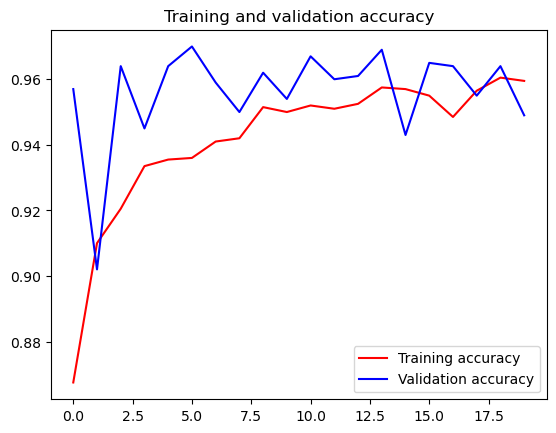

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Descargar el dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

# Extraer el archivo
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Definir los directorios de ejemplo y archivos
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con imágenes de gatos para entrenamiento
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con imágenes de perros para entrenamiento
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con imágenes de gatos para validación
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con imágenes de perros para validación
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Añadir nuestros parámetros de aumento de datos a ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Notar que los datos de validación no deben ser aumentados!
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generar imágenes de entrenamiento en lotes de 8 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=8,
    class_mode='binary',
    target_size=(100, 100)
)

# Generar imágenes de validación en lotes de 8 usando el generador test_datagen
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=8,
    class_mode='binary',
    target_size=(100, 100)
)

# Descargar los pesos preentrenados
local_weights_file = tf.keras.utils.get_file(
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    cache_subdir='models',
    cache_dir='/tmp'
)

# Inicializa el modelo base InceptionV3 sin las capas superiores (capas densas)
pre_trained_model = InceptionV3(input_shape=(100, 100, 3), include_top=False, weights=None)

# Carga los pesos preentrenados descargados
pre_trained_model.load_weights(local_weights_file)

# Congela los pesos de las capas para que no se entrenen durante el ajuste del modelo
for layer in pre_trained_model.layers:
    layer.trainable = False

# Obtener la salida de una capa intermedia
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Aplana la salida a 1 dimensión
x = layers.Flatten()(last_output)
# Añadir una capa densa completamente conectada con 512 unidades y activación ReLU
x = layers.Dense(512, activation='relu')(x)
# Añadir una capa de dropout con una tasa de 0.2
x = layers.Dropout(0.2)(x)
# Añadir una capa final con activación sigmoid para la clasificación binaria
x = layers.Dense(1, activation='sigmoid')(x)

# Crear el modelo completo
model = Model(pre_trained_model.input, x)

# Compilar el modelo para un problema de clasificación binaria
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Calcular steps_per_epoch
total_train_images = len(train_generator.filenames)
steps_per_epoch = total_train_images // 8

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_steps=50,
    verbose=2
)


--2024-06-02 18:21:53--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.155, 172.217.17.27, 172.217.168.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: 'cats_and_dogs_filtered.zip.5'

     0K .......... .......... .......... .......... ..........  0%  398K 2m48s
    50K .......... .......... .......... .......... ..........  0%  403K 2m47s
   100K .......... .......... .......... .......... ..........  0%  684K 2m24s
   150K .......... .......... .......... .......... ..........  0%  992K 2m5s
   200K .......... .......... .......... .......... ..........  0% 1,38M 1m49s
   250K .......... .......... .......... .......... ..........  0% 2,01M 96s
   300K .......... .......... .......... .......... ..........  0% 1,89M 87s

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
last layer output shape:  (None, 4, 4, 768)
Epoch 1/20
250/250 - 14s - loss: 0.4085 - accuracy: 0.8200 - val_loss: 0.3683 - val_accuracy: 0.8475
Epoch 2/20
250/250 - 13s - loss: 0.3388 - accuracy: 0.8615 - val_loss: 0.3418 - val_accuracy: 0.8850
Epoch 3/20
250/250 - 13s - loss: 0.2825 - accuracy: 0.8950 - val_loss: 0.2800 - val_accuracy: 0.9000
Epoch 4/20
250/250 - 13s - loss: 0.2619 - accuracy: 0.8995 - val_loss: 0.2190 - val_accuracy: 0.9175
Epoch 5/20
250/250 - 13s - loss: 0.2616 - accuracy: 0.8960 - val_loss: 0.2828 - val_accuracy: 0.8900
Epoch 6/20
250/250 - 13s - loss: 0.2344 - accuracy: 0.9055 - val_loss: 0.4270 - val_accuracy: 0.8475
Epoch 7/20
250/250 - 13s - loss: 0.2359 - accuracy: 0.9090 - val_loss: 0.2367 - val_accuracy: 0.9025
Epoch 8/20
250/250 - 13s - loss: 0.2165 - accuracy: 0.9175 - val_loss: 0.2403 - val_accuracy: 0.9200
Epoch 9/20
250/250 - 13s - loss: 0.2199 - accuracy: 0.9155 - val

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [13]:
!pip install tensorflow-gpu


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 36, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Pedro\AppData\Local\Temp\pip-install-3a06j9yv\tensorflow-gpu_025627d4fd5c4908a960d0b77ba86764\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did no

##### Choose a separate last layer as the last layer of your base model, and re-run everything. What did you observe? Share your findings with the class